#Importing relevant Libraries

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#Loading Dataset

In [0]:
PATH = '/content/drive/My Drive/Colab Notebooks/Capstone Project/'

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv(PATH+'Data/capstone_train.csv')
test = pd.read_csv(PATH+'Data/capstone_test.csv')

In [59]:
plantDf = pd.concat([train,test])
plantDf.shape

(581012, 13)

In [60]:
plantDf['Plant_Type'].value_counts()

Assassin vine    283301
Ascomoid         211840
Basidirond        35754
Myconid:          20510
Kelpie            17367
Hangman tree       9493
Dark tree          2747
Name: Plant_Type, dtype: int64

#Label Encoding on "Plant_Type"

In [0]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
plantDf['Cat_Plant_Type'] = label_encoder.fit_transform(plantDf['Plant_Type'])

In [62]:
plantDf.sample(10)

,Heigh_From_Sea_Level,Aspect,Slope,Distance_To_Water_Source,Standing_Distance_To_Water_Source,Distance_To_Road,Shadow_In_Morning,Shadow_In_Midday,Shadow_In_Evening,Distance_To_Fire,Turf,Neighbourhood_Type,Plant_Type,Cat_Plant_Type
361774,3017,297,3,95,11,4302,210,238.0,166,860,29,1,Assassin vine,1
419124,2694,341,12,234,16,1994,194,222.0,166,1604,32,3,Assassin vine,1
368231,1905,356,32,108,56,90,151,164.0,137,631,5,4,Kelpie,5
226918,2973,34,9,335,86,3932,219,221.0,138,2493,30,1,Assassin vine,1
287161,2264,109,39,255,160,858,252,167.0,0,306,3,4,Dark tree,3
37883,3138,25,11,457,40,1798,215,216.0,137,3494,31,3,Ascomoid,0
314553,2763,32,13,60,14,1261,216,210.0,127,2407,31,3,Assassin vine,1
308571,2387,63,20,108,38,531,233,NaN,84,1148,10,4,Basidirond,2
456816,2852,34,25,366,62,600,207,176.0,92,782,33,3,Ascomoid,0
137327,2998,109,9,607,26,5542,235,231.0,127,6427,20,1,Ascomoid,0


In [0]:
plantDf.drop('Plant_Type', axis = 1, inplace = True)

In [64]:
plantDf['Cat_Plant_Type'].value_counts()

1    283301
0    211840
2     35754
6     20510
5     17367
4      9493
3      2747
Name: Cat_Plant_Type, dtype: int64

In [0]:
Plant_Type_Labels = {'Assassin vine' : 1, 'Ascomoid' : 0, 'Basidirond' : 2, 
                     'Myconid:' : 6, 'Kelpie' : 5, 'Hangman tree' : 4,
                     'Dark tree' : 3}

#Treating NaN values in "Shadow_In_Midday"

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics

In [0]:
plantDfWithoutNan = plantDf[plantDf['Shadow_In_Midday'].notnull()]

In [68]:
plantDfWithoutNan.shape

(464900, 13)

###Training Model

In [0]:
x = plantDfWithoutNan.drop('Shadow_In_Midday', axis = 1)
x = x.values
y = plantDfWithoutNan['Shadow_In_Midday']
y = y.values

In [0]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = .2, 
                                                random_state = 5)

In [0]:
reg = linear_model.LinearRegression()

In [72]:
reg.fit(xTrain, yTrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [73]:
print('Coefficients: \n', reg.coef_)

Coefficients: 
 [ 4.79827937e-04  2.30084082e-03  8.73280937e-01 -4.86644641e-04
  8.96697174e-04  8.65144747e-05  1.18482248e+00  9.79240885e-01
 -6.16551273e-05 -4.41937686e-02 -8.88525541e-02  3.41245272e-02]


In [74]:
print('Variance score: ', reg.score(xTest, yTest))

Variance score:  0.9733146506527277


In [0]:
yTrainPred = reg.predict(xTrain)
yTestPred = reg.predict(xTest)

In [76]:
print('r2 score on Train: ', metrics.r2_score(yTrain, yTrainPred))
print('r2 score on Test: ', metrics.r2_score(yTest, yTestPred))

r2 score on Train:  0.9744409926154162
r2 score on Test:  0.9733146506527277


###Imputing predicted Values

In [0]:
plantDfWithNan = plantDf[plantDf['Shadow_In_Midday'].isnull()]
inputFeatures = plantDfWithNan.drop('Shadow_In_Midday', axis = 1)

In [0]:
targetPred = reg.predict(inputFeatures)

In [79]:
plantDf['Shadow_In_Midday'][plantDf['Shadow_In_Midday'].isnull()] = targetPred.round().astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [80]:
plantDf.isna().sum()

Heigh_From_Sea_Level                 0
Aspect                               0
Slope                                0
Distance_To_Water_Source             0
Standing_Distance_To_Water_Source    0
Distance_To_Road                     0
Shadow_In_Morning                    0
Shadow_In_Midday                     0
Shadow_In_Evening                    0
Distance_To_Fire                     0
Turf                                 0
Neighbourhood_Type                   0
Cat_Plant_Type                       0
dtype: int64

#Computing Average Sunlight Feature

In [0]:
plantDf['Avg_Sunlight']=((255*3-(plantDf['Shadow_In_Morning']+plantDf['Shadow_In_Midday']+plantDf['Shadow_In_Evening']))/3)

#Computing Average Distance from Water Feature

In [0]:
plantDf['Avg_Dist_Water'] = (plantDf['Distance_To_Water_Source']**2+plantDf['Standing_Distance_To_Water_Source']**2)**0.5

#Correlation

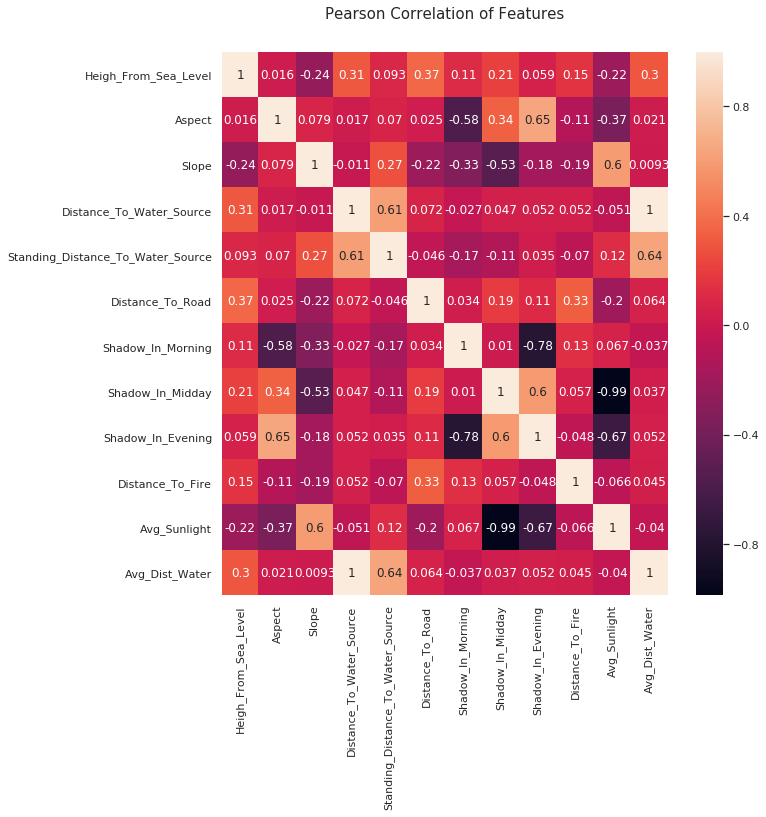

In [83]:
plantDfNum = plantDf.drop(['Turf', 'Neighbourhood_Type', 'Cat_Plant_Type'], axis=1)

sns.set(rc={'figure.figsize':(10,10)})
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(plantDfNum.corr(), annot=True)

#Inference on Required Sunlight

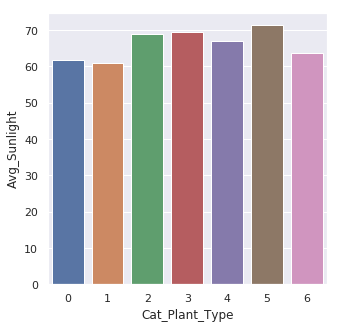

In [89]:
sns.set(rc={'figure.figsize':(5,5)})
sns.barplot(x=plantDf.groupby('Cat_Plant_Type')['Avg_Sunlight'].mean().index, y=plantDf.groupby('Cat_Plant_Type')['Avg_Sunlight'].mean())

In [92]:
print(Plant_Type_Labels)

{'Assassin vine': 1, 'Ascomoid': 0, 'Basidirond': 2, 'Myconid:': 6, 'Kelpie': 5, 'Hangman tree': 4, 'Dark tree': 3}


Ineferences :

1. Kelpie is getting more sunlight as compared to others.
2. Sunlight requirements of Basidirond and Dark Tree are almost similar and more than Assasin Vine, Ascomoid, Hangman Tree and Myconid.
3. Sunlight requirements of Myconid and Hangman tree are moderate.
4. Sunlight requirements of Assassin Vine and Ascomoid are similar and leat of all.

#Inference on Required Water

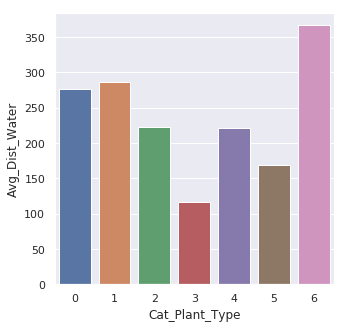

In [90]:
sns.barplot(x=plantDf.groupby('Cat_Plant_Type')['Avg_Dist_Water'].mean().index, y=plantDf.groupby('Cat_Plant_Type')['Avg_Dist_Water'].mean())

In [93]:
print(Plant_Type_Labels)

{'Assassin vine': 1, 'Ascomoid': 0, 'Basidirond': 2, 'Myconid:': 6, 'Kelpie': 5, 'Hangman tree': 4, 'Dark tree': 3}


Inferences : 
1. Water Requirements of Myconid are highest of all.
2. Water Requirements of Assasin vine and Ascomoid are moderate and more than others.
3. Water Requirements of Basidirond, Hangman tree are lower as compared to Assasin Vine, Ascomoid and Mycoind.
4. Dark tree has the leat water requirement.

#Clustering

In [0]:
clusteringDf = plantDf.filter(['Avg_Dist_Water', 'Avg_Sunlight', 'Cat_Plant_Type'])

##Scaling

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

clusteringDf[['Avg_Dist_Water', 'Avg_Sunlight']] = scaler.fit_transform(clusteringDf[['Avg_Dist_Water', 'Avg_Sunlight']])

##KMeans

In [0]:
from sklearn.cluster import KMeans

In [0]:
wcss = []    #Within cluster sum of squares

for i in range(1,11):
  km = KMeans(n_clusters=i)
  km.fit(clusteringDf[['Avg_Dist_Water', 'Avg_Sunlight']])
  wcss.append(km.inertia_)

[16198.347071541102, 7155.252090887391, 4861.6884251484025, 3784.695337667067, 2919.6286936427027, 2497.7783597244334, 2178.846787621532, 1942.7051950322077, 1735.447336139294, 1546.9564220955426]


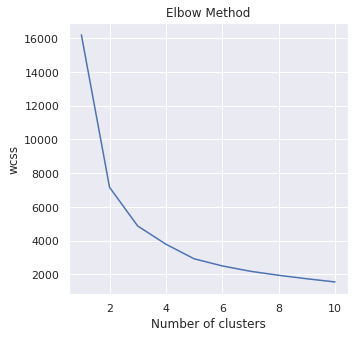

In [156]:
print(wcss)
plt.plot(np.array(range(1,11)),np.array(wcss))
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [0]:
km = KMeans(n_clusters=4)
yPred = km.fit_predict(clusteringDf[['Avg_Dist_Water', 'Avg_Sunlight']])

In [0]:
clusteringDf['Type']=yPred

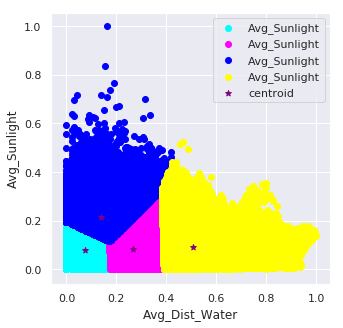

In [145]:
df1 = clusteringDf[clusteringDf.Type==0]
df2 = clusteringDf[clusteringDf.Type==1]
df3 = clusteringDf[clusteringDf.Type==2]
df4 = clusteringDf[clusteringDf.Type==3]

plt.scatter(df1.Avg_Dist_Water,df1.Avg_Sunlight,color='cyan')
plt.scatter(df2.Avg_Dist_Water,df2.Avg_Sunlight,color='magenta')
plt.scatter(df3.Avg_Dist_Water,df3.Avg_Sunlight,color='blue')
plt.scatter(df4.Avg_Dist_Water,df4.Avg_Sunlight,color='yellow')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',label='centroid')
plt.xlabel('Avg_Dist_Water')
plt.ylabel('Avg_Sunlight')
plt.legend()


In [146]:
df1['Cat_Plant_Type'].value_counts()/clusteringDf['Cat_Plant_Type'].value_counts() #Low Water | Low Sunlight

0    0.457501
1    0.423606
2    0.385663
3    0.564616
4    0.448541
5    0.453331
6    0.347245
Name: Cat_Plant_Type, dtype: float64

In [147]:
df2['Cat_Plant_Type'].value_counts()/clusteringDf['Cat_Plant_Type'].value_counts() #Moderate Water | Low Sunlight

1    0.341573
0    0.302917
2    0.285451
6    0.274939
5    0.187137
4    0.225745
3    0.147070
Name: Cat_Plant_Type, dtype: float64

In [148]:
df3['Cat_Plant_Type'].value_counts()/clusteringDf['Cat_Plant_Type'].value_counts() #Low Water | High Sunlight

0    0.112675
1    0.116738
2    0.302064
3    0.283218
4    0.265775
5    0.353429
6    0.135397
Name: Cat_Plant_Type, dtype: float64

In [149]:
df4['Cat_Plant_Type'].value_counts()/clusteringDf['Cat_Plant_Type'].value_counts() #High Water | High Sunlight

0    0.126907
1    0.118083
2    0.026822
3    0.005096
4    0.059939
5    0.006104
6    0.242418
Name: Cat_Plant_Type, dtype: float64

Inference : 
1. Low water and Low Sunglight requirement seems to be most suitable for all plant types.
2. High water and Low Sunglight requirement seems to be most unsuitable for all plant types.